## Lead Scoring - Case Study

### Goals of the Case Study
Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. 

These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

In [60]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Import all required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


### Data Load & Inpsection

In [61]:
leads_data = pd.read_csv("Leads.csv")
leads_data.head(5)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [62]:
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

### Data Cleaning:
- Remove N/A or similar values 
- Drop columns with high missing values
- Drop rows with more than 5 missing columns
- Impute values as required
- Check categorical columns
- Check the final percentage

In [63]:
# Helper function to convert Yes/No values
def yesno(x):
    if x.upper() == 'YES':
        return 1
    else:
        return 0

In [64]:
# Helper function to cleanup data.
# 1. Convert 'Select' values to null
# 2. Drop columns where null count is high.
# 3. Drop columns if more that 90% of values are a single value or null (Ex: Country)
# 4. Convert Yes/No vlaues to 1/0 flags
def data_cleanup(featurelist):
    for afeature in featurelist:
        if leads_data.dtypes[afeature] == 'object':
            print('')
            print(afeature + ':')
            # We know there are 'Select' values in the columns, let's change those to NaN
            print('    Values as "Select":', len(leads_data[leads_data[afeature] == 'Select']))
            leads_data.replace('Select', np.NaN, inplace=True)
            #print('Select values replaced')

            values = pd.DataFrame(leads_data[afeature].value_counts())
            values.reset_index(inplace=True)  

            if 0.5 < (leads_data[afeature].isnull().sum()/len(leads_data)):
                print('    Null %:', leads_data[afeature].isnull().sum()/len(leads_data), ': Column dropped.')
                leads_data.drop(columns=afeature, inplace=True)
                continue
            
            #print('Null count check passed...')

            null_count = leads_data[afeature].isnull().sum()
            # Now let's check the top value, if that is 90% of the values then the column is not useful, so we drop them.
            if values.iloc[0, 1] + null_count > 0.9 * len(leads_data):
                print('   ', values.iloc[0, 0], ':', values.iloc[0, 1], ' : Column dropped as more than 90% are a single value or null')
                leads_data.drop(columns=afeature, inplace=True)
                continue

            #print('Skewed values check passed...')

            #Convert Yes/No columns remaining to 1/0
            if values.iloc[0, 0] in ['Yes', 'No']:
                leads_data[afeature] = leads_data[afeature].map(lambda x: yesno(x))
                print('    Converted Yes/No')
                #print('Yes/No values converted to 1/0...')

            print(leads_data[afeature].value_counts())            


In [65]:
data_cleanup(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity'])


Lead Origin:
    Values as "Select": 0
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

Lead Source:
    Values as "Select": 0
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
NC_EDM                  1
welearnblog_Home        1
youtubechannel          1
WeLearn                 1
Pay per Click Ads       1
testone                 1
blog                    1
Name: Lead Source, dtype: int64

Do Not Email:
    Values as "Select": 0
    No : 8506  : Column dropped as more than 90% are a single value or null

Do Not Call:
    Values as "Sele

In [66]:
# We have 15 features and 3 index columns and 1 target column remaining.
# Let's drop the rows where 5 or more values are missing.add_constant
leads_data.dropna(thresh=11, inplace=True)
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9219 entries, 0 to 9239
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Prospect ID                             9219 non-null   object 
 1   Lead Number                             9219 non-null   int64  
 2   Lead Origin                             9219 non-null   object 
 3   Lead Source                             9185 non-null   object 
 4   Converted                               9219 non-null   int64  
 5   TotalVisits                             9103 non-null   float64
 6   Total Time Spent on Website             9219 non-null   int64  
 7   Page Views Per Visit                    9103 non-null   float64
 8   Last Activity                           9136 non-null   object 
 9   Specialization                          5860 non-null   object 
 10  What is your current occupation         6529 non-null   obje

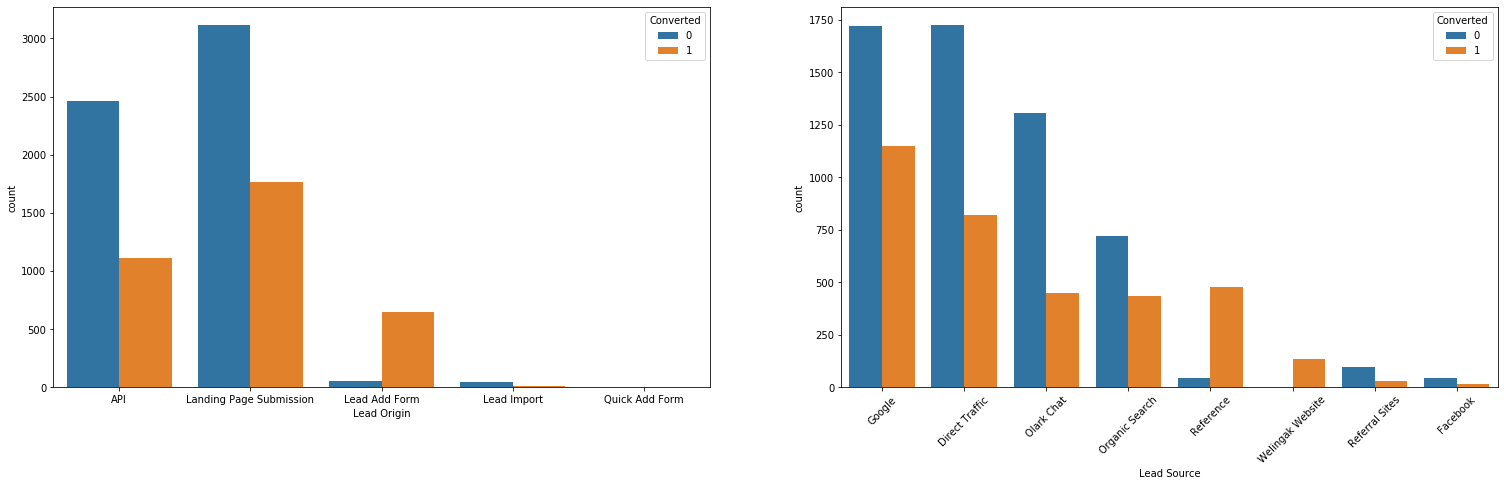

In [67]:
# Let's visualize the data to see the distribution
plt.figure(figsize=(40, 7))
plt.subplot(131)
sns.countplot(x='Lead Origin', data=leads_data, hue='Converted')
plt.subplot(132)
sns.countplot(x='Lead Source', data=leads_data, hue='Converted', order=leads_data['Lead Source'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

The Lead Origin types contribute similarly to the Conversion, except for "Lead Add Form" which has a very high conversion ratio.
The Lead Source also follows a similar ratio for conversion, however, Referral Sites and Welingak Website Reference have exceptional conversion rates.

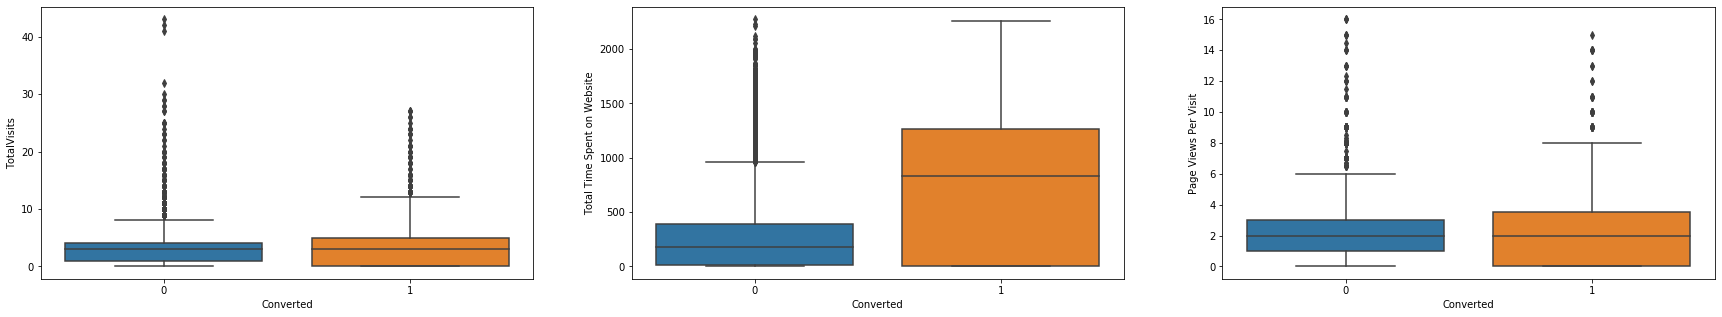

In [68]:
plt.figure(figsize=(30, 5))
plt.subplot(131)
sns.boxplot(x='Converted', y='TotalVisits', data=leads_data[leads_data['TotalVisits']<50])
plt.subplot(132)
sns.boxplot(x='Converted', y='Total Time Spent on Website', data=leads_data)
plt.subplot(133)
sns.boxplot(x='Converted', y='Page Views Per Visit', data=leads_data[leads_data['Page Views Per Visit'] < 20])
plt.show()

These are numerical values, plotted by Conversion rate.
This shows that total time spent on website is much higher by the leads that are converted.

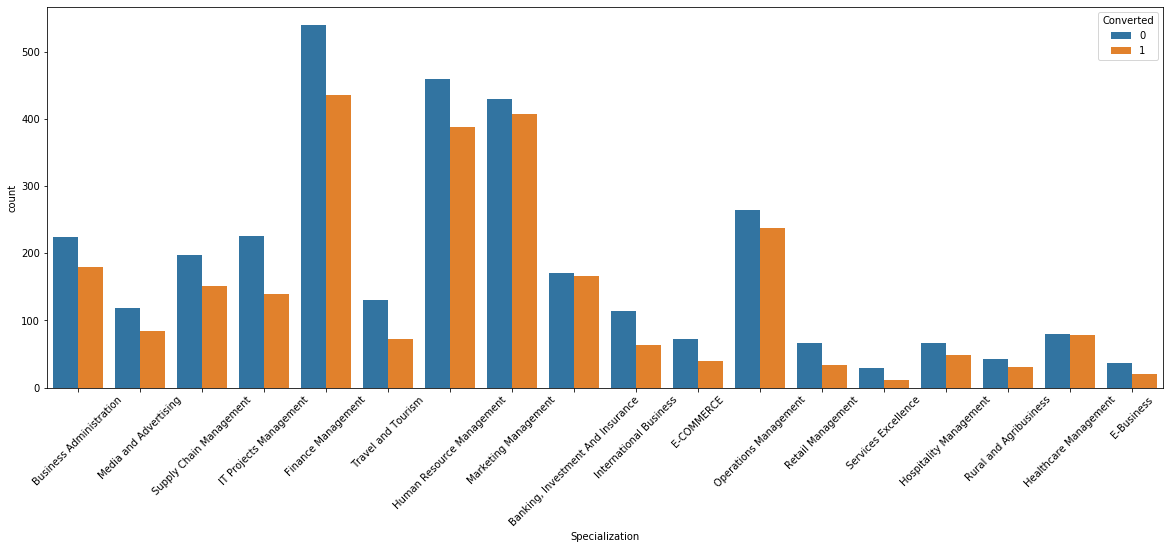

In [69]:
plt.figure(figsize=(20, 7))
sns.countplot(x='Specialization', data=leads_data, hue='Converted')
plt.xticks(rotation=45)
plt.show()

Specialization does not have much bearing on the conversion rate.

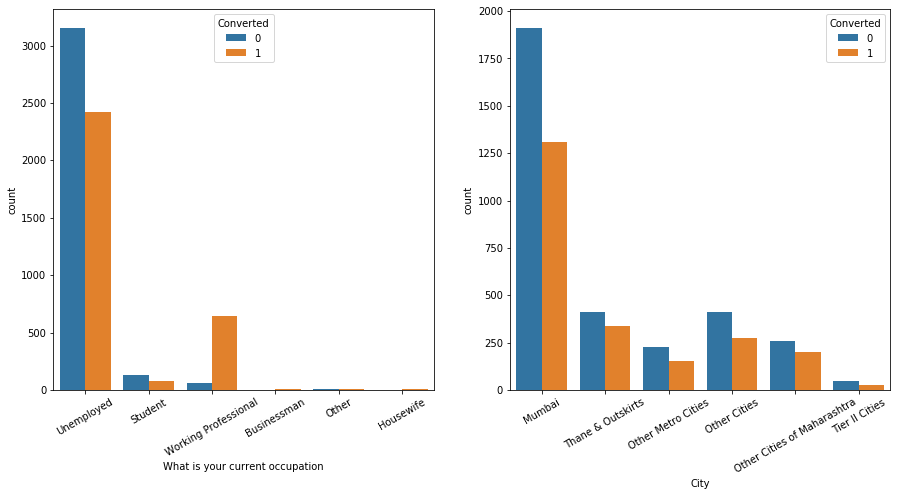

In [70]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.countplot(x='What is your current occupation', data=leads_data, hue='Converted')
plt.xticks(rotation=30)
plt.subplot(122)
sns.countplot(x='City', data=leads_data, hue='Converted')
plt.xticks(rotation=30)
plt.show()

City and current occupation also do not have much effect, except for Working Professional category that have a good conversion rate.

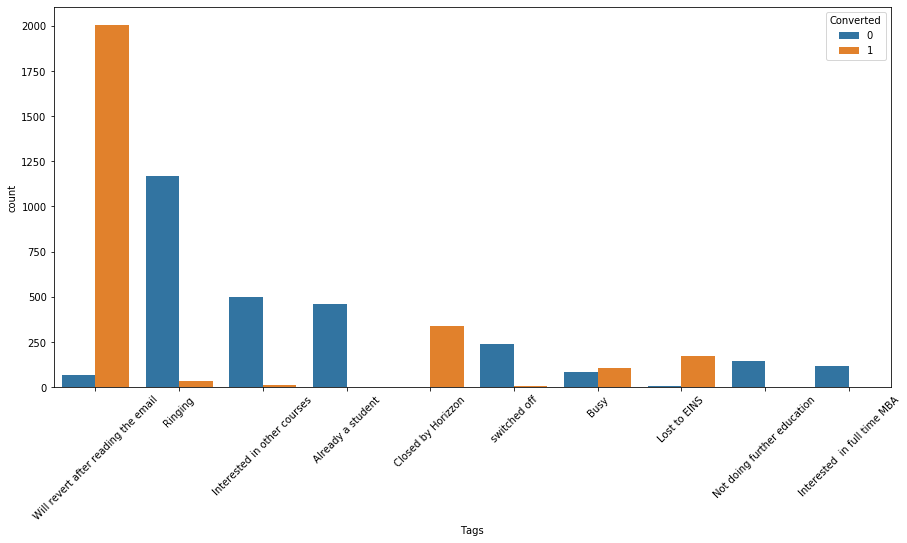

In [71]:
plt.figure(figsize=(15, 7))
sns.countplot(x='Tags', data=leads_data, hue='Converted', order=leads_data.Tags.value_counts().iloc[:10].index)
plt.xticks(rotation=45)
plt.show()


Tags column has 3 different categories that have significantly higher conversion rate. "Will Revert...", "Lost to EINS", "Closed by Horizzon" almost guarantee a conversion. 
There are some categories that quarantee a non-conversion too, such as "interested in other...". "Ringin", "Already a student" These features would have negative coefficients if found to be significant.

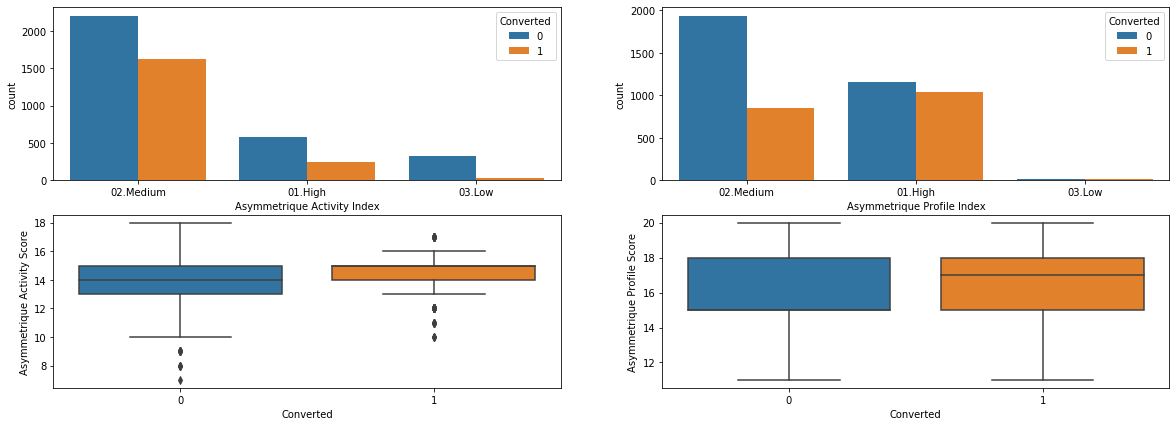

In [72]:
plt.figure(figsize=(20, 7))
plt.subplot(221)
sns.countplot(x='Asymmetrique Activity Index', data=leads_data, hue='Converted')
plt.subplot(222)
sns.countplot(x='Asymmetrique Profile Index', data=leads_data, hue='Converted')
plt.subplot(223)
sns.boxplot(x='Converted', y='Asymmetrique Activity Score', data=leads_data)
plt.subplot(224)
sns.boxplot(x='Converted', y='Asymmetrique Profile Score', data=leads_data)
plt.show()


All the 4 data points stack up similarly for the conversion rate, they do not seem to have much bearing.

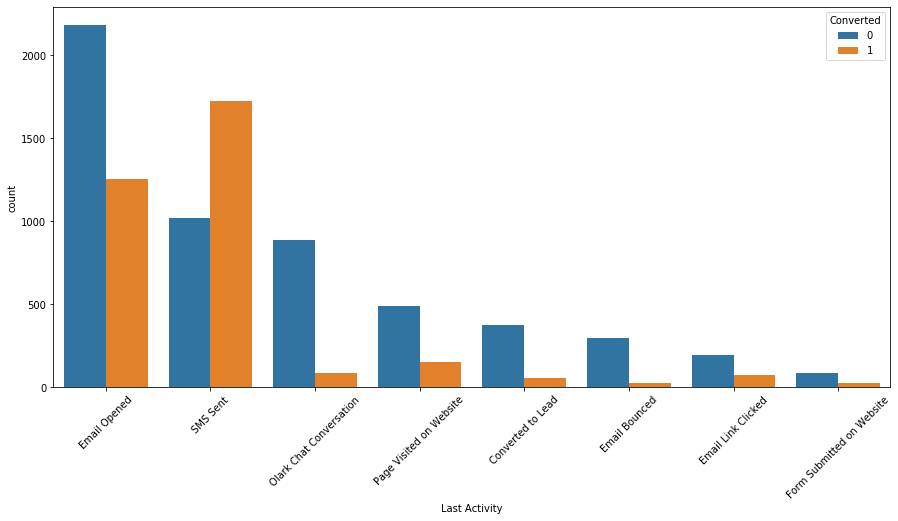

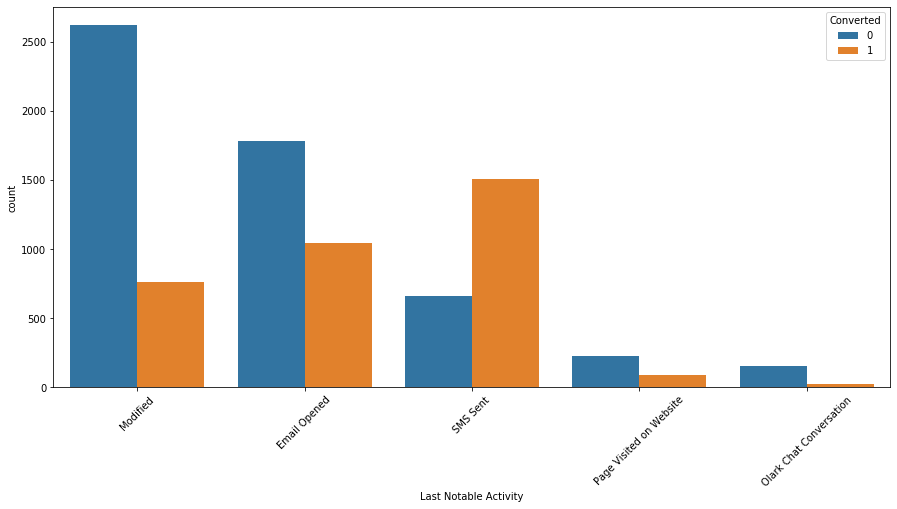

In [73]:
plt.figure(figsize=(15, 7))
sns.countplot(x='Last Activity', data=leads_data, hue='Converted', order=leads_data['Last Activity'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 7))
sns.countplot(x='Last Notable Activity', data=leads_data, hue='Converted', order=leads_data['Last Notable Activity'].value_counts().iloc[:5].index)
plt.xticks(rotation=45)
plt.show()

Both Last Activity and Last Notable Activity do not have any significant category afffecting the conversion rate, except for SMS Sent which has a high conversion rate.

Through out the EDA, we also ignored the categories that have very less number of entries. Since a smaller samples may not give us accurate significance for the value.

In [74]:
# Since the categorical values would be converted to dummies, we can leave the null values as is. 
# However the numerical values need to be imputed. We will impute with the simplest replacement i.e. the mean.
col_filter = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'A free copy of Mastering The Interview']
for i in col_filter:
    leads_data[i][leads_data[i].isnull()] = leads_data[i].mean()
#For the numerical values, we are imputing the values by the mean.
leads_data.isnull().sum()

Prospect ID                                  0
Lead Number                                  0
Lead Origin                                  0
Lead Source                                 34
Converted                                    0
TotalVisits                                  0
Total Time Spent on Website                  0
Page Views Per Visit                         0
Last Activity                               83
Specialization                            3359
What is your current occupation           2690
Tags                                      3350
City                                      3648
Asymmetrique Activity Index               4197
Asymmetrique Profile Index                4197
Asymmetrique Activity Score                  0
Asymmetrique Profile Score                   0
A free copy of Mastering The Interview       0
Last Notable Activity                        0
dtype: int64

In [75]:
#Lastly let's drop the prospect ID and Lead Number, as these are just Ids.
leads_data.set_index('Prospect ID', inplace=True)
leads_data.drop(columns=['Lead Number'], inplace=True)

### Data Preparation:
- Create dummies
- Train - test split
- Perform Scaling


In [76]:
# Note that since all categorical columns have null values, we are not removing the first entry.
# So each valid value will get a dummy column and null value will have all flags as 0.
leads_data = pd.get_dummies(data=leads_data)
leads_data.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
Prospect ID,,,,,,,,,,,,,,,,,,,,,
7927b2df-8bba-4d29-b9a2-b6e0beafe620,0,0.0,0,0.0,15.0,15.0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2a272436-5132-4136-86fa-dcc88c88f482,0,5.0,674,2.5,15.0,15.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8cc8c611-a219-4f35-ad23-fdfd2656bd8a,1,2.0,1532,2.0,14.0,20.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0cc2df48-7cf4-4e39-9de9-19797f9b38cc,0,1.0,305,1.0,13.0,17.0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3256f628-e534-4826-9d63-4a8b88782852,1,2.0,1428,1.0,15.0,18.0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [77]:
#Split the training data in 70/30 ratio
leads_data_train, leads_data_test = train_test_split(leads_data, test_size=0.3, random_state=10)

print(leads_data_train.shape)
print(leads_data_test.shape)

(6453, 128)
(2766, 128)


In [78]:
# We will use a StandardScaler to scale the numerical data, not scaling the 1/0 flags
scaler = StandardScaler()
col_filter = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'A free copy of Mastering The Interview']
leads_data_train[col_filter] = scaler.fit_transform(leads_data_train[col_filter])
leads_data_test[col_filter] = scaler.transform(leads_data_test[col_filter])
leads_data_train.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
Prospect ID,,,,,,,,,,,,,,,,,,,,,
d262e52a-b8e1-4164-b869-bb199ddf75a9,0,0.298138,-0.527769,1.304997,-0.297483,-1.018059,-0.673820,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8e7c901c-2310-4401-a95d-2017b119e9ca,0,-0.277745,0.876928,-0.160863,0.003905,-0.013638,1.484076,0,1,0,...,0,0,0,0,0,0,0,0,0,0
dbaafb73-af3f-4963-b146-a923038210ea,1,-0.661667,-0.890331,-1.138103,0.003905,-0.013638,-0.673820,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31c3877c-b41e-44aa-a9b2-9e56c788c87b,0,0.106177,-0.300030,0.816377,-0.297483,2.716171,-0.673820,0,1,0,...,0,0,1,0,0,0,0,0,0,0
a8672970-1a5d-48c9-a376-821853b6d180,1,-0.000316,-0.108729,0.016418,-0.297483,-1.018059,-0.673820,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [79]:
# Dividing into x & y
leads_data_train_X = leads_data_train.drop(columns=['Converted'])
leads_data_train_y = pd.DataFrame(leads_data_train['Converted'])
leads_data_test_X = leads_data_test.drop(columns=['Converted'])
leads_data_test_y  = pd.DataFrame(leads_data_test['Converted'])

print(leads_data_train_X.shape)
print(leads_data_train_y.shape)
print(leads_data_test_X.shape)
print(leads_data_test_y.shape)

(6453, 127)
(6453, 1)
(2766, 127)
(2766, 1)


### Modelling:
- RFE to choose 15 columns
- Build Logistic Regression
- Check p-value and VIF
- Find the optimal probability cutoff
- Check the model performance
    - Confusion MAtrix
    - Sensitivity
    - F1- Scrore
    - ROC Curve
    - For both train & test
- Generate the score variable


In [80]:
#Creating the Logistic Regression model
lg = LogisticRegression()
lg.fit(leads_data_train_X, leads_data_train_y)

#Running RFE to select 20 features.
rfe = RFE(lg, 15)
rfe = rfe.fit(leads_data_train_X, leads_data_train_y)

[i for i in list(zip(leads_data_train_X.columns, rfe.support_, rfe.ranking_)) if i[2] <= 6]

[('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Email Bounced', False, 6),
 ('What is your current occupation_Unemployed', False, 5),
 ('What is your current occupation_Working Professional', False, 4),
 ('Tags_Already a student', True, 1),
 ('Tags_Closed by Horizzon', True, 1),
 ('Tags_Diploma holder (Not Eligible)', True, 1),
 ('Tags_Graduation in progress', False, 3),
 ('Tags_Interested  in full time MBA', False, 2),
 ('Tags_Interested in other courses', True, 1),
 ('Tags_Lost to EINS', True, 1),
 ('Tags_Not doing further education', True, 1),
 ('Tags_Ringing', True, 1),
 ('Tags_Will revert after reading the email', True, 1),
 ('Tags_invalid number', True, 1),
 ('Tags_number not provided', True, 1),
 ('Tags_opp hangup', True, 1),
 ('Tags_switched off', True, 1),
 ('Tags_wrong number given', True, 1),
 ('Last Notable Activity_SMS Sent', True, 1)]

### Checking for correlation on the categories that were found significant during EDA but are missing after RFE.

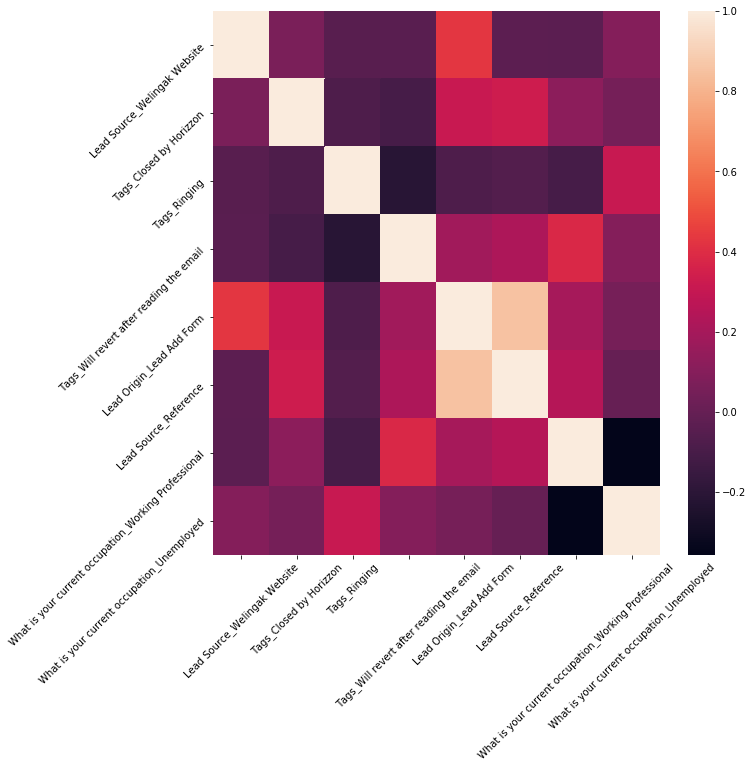

In [81]:
leads_corr = leads_data[['Lead Source_Welingak Website', 'Tags_Closed by Horizzon', 'Tags_Ringing', 'Tags_Will revert after reading the email', 'Lead Origin_Lead Add Form', 'Lead Source_Reference', 'What is your current occupation_Working Professional', 'What is your current occupation_Unemployed']].corr()
plt.figure(figsize = (10,10))
sns.heatmap(leads_corr)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

We see the columns identified during EDA figure with RFE process too. Except for Category Working Professional all identified categories are found to be significant. 
The Tag column also has a pretty high number of significant categories, as we found during EDA.

** The below columns are hence found to be useful for the Logistic Regression Model. **

In [82]:
col_filter = leads_data_train_X.columns[rfe.support_]
col_filter

Index(['Lead Source_Welingak Website', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_number not provided', 'Tags_opp hangup', 'Tags_switched off',
       'Tags_wrong number given', 'Last Notable Activity_SMS Sent'],
      dtype='object')

### Check the performance of the model selected
#### Assessing the model with StatsModels

In [83]:
train_sm = sm.add_constant(leads_data_train_X[col_filter])
lg = sm.GLM(leads_data_train_y, train_sm, family = sm.families.Binomial()).fit()
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6453
Model:                            GLM   Df Residuals:                     6437
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1492.5
Date:                Sat, 06 Jun 2020   Deviance:                       2985.1
Time:                        20:18:24   Pearson chi2:                 8.17e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.8528      0.062    -29.814      0.000      -1.975      -1.731
Lead Source_Welingak Website                 4.4756      0.732      6.111      0.000       3.040       5.911
Tags_Already a student                      -3.2592      0.712     -4.578      0.000      -4.655      -1.864
Tags_Closed by Horizzon                      7.2562      1.004      7.226      0.000       5.288       9.224
Tags_Diploma holder (Not Eligible)          -2.0968      1.041     -2.015      0.044      -4.136      -0.057
Tags_Interested in other courses            -1.7695      0.307     -5.769      0.000      -2.371      -1.168
Tags_Lost to EINS                            5.4086      0.589      9.185      0.000       4.255       6.563
Tags_Not doing further education            -2.9908      1.012     -2.955      0.003      -4.974      -1.007
Tags_Ringing                                -3.5003      0.230    -15.213      0.000      -3.951      -3.049
Tags_Will revert after reading the email     4.8211      0.172     27.956      0.000       4.483       5.159
Tags_invalid number                        -24.1044   1.65e+04     -0.001      0.999   -3.23e+04    3.22e+04
Tags_number not provided                   -24.4465   2.75e+04     -0.001      0.999   -5.39e+04    5.39e+04
Tags_opp hangup                             -2.9046      1.065     -2.728      0.006      -4.992      -0.818
Tags_switched off                           -4.0426      0.597     -6.774      0.000      -5.212      -2.873
Tags_wrong number given                    -24.1797   1.97e+04     -0.001      0.999   -3.85e+04    3.85e+04
Last Notable Activity_SMS Sent               2.8191      0.118     23.943      0.000       2.588       3.050
============================================================================================================
"""

This model looks good however, and we see pretty strong coefficients for some of the features. 
LEt's use the model to predict the values.

In [99]:
col_filter = ['Lead Source_Welingak Website', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_opp hangup', 'Tags_switched off',
       'Last Notable Activity_SMS Sent']
train_sm = sm.add_constant(leads_data_train_X[col_filter])
#train_sm = sm.add_constant(leads_data_train_X[col_filter])
lg = sm.GLM(leads_data_train_y, train_sm, family = sm.families.Binomial()).fit()
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6453
Model:                            GLM   Df Residuals:                     6440
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1539.3
Date:                Sat, 06 Jun 2020   Deviance:                       3078.7
Time:                        20:19:48   Pearson chi2:                 7.80e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.8955      0.062    -30.564      0.000      -2.017      -1.774
Lead Source_Welingak Website                 4.5341      0.732      6.196      0.000       3.100       5.968
Tags_Already a student                      -3.2165      0.712     -4.518      0.000      -4.612      -1.821
Tags_Closed by Horizzon                      7.2988      1.004      7.269      0.000       5.331       9.267
Tags_Diploma holder (Not Eligible)          -2.0225      1.035     -1.954      0.051      -4.051       0.006
Tags_Interested in other courses            -1.7019      0.305     -5.579      0.000      -2.300      -1.104
Tags_Lost to EINS                            5.4513      0.589      9.258      0.000       4.297       6.605
Tags_Not doing further education            -2.9317      1.011     -2.901      0.004      -4.912      -0.951
Tags_Ringing                                -3.3128      0.227    -14.604      0.000      -3.757      -2.868
Tags_Will revert after reading the email     4.8733      0.172     28.302      0.000       4.536       5.211
Tags_opp hangup                             -2.7201      1.062     -2.562      0.010      -4.801      -0.639
Tags_switched off                           -3.8509      0.595     -6.470      0.000      -5.018      -2.684
Last Notable Activity_SMS Sent               2.6536      0.112     23.781      0.000       2.435       2.872
============================================================================================================
"""

In [100]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = leads_data_train_X[col_filter].columns
vif['VIF'] = [variance_inflation_factor(leads_data_train_X[col_filter].values, i) for i in range(leads_data_train_X[col_filter].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,Lead Source_Welingak Website,1.03
10,Tags_switched off,1.02
2,Tags_Closed by Horizzon,1.01
3,Tags_Diploma holder (Not Eligible),1.00
5,Tags_Lost to EINS,1.00
6,Tags_Not doing further education,1.00
9,Tags_opp hangup,1.00
4,Tags_Interested in other courses,0.32
1,Tags_Already a student,0.23
8,Tags_Will revert after reading the email,0.14


The VIF for all the columns look great, so there is no need to change the column selection.

In [101]:
# Getting the predicted values on the train set
y_train_pred = lg.predict(train_sm)
y_train_pred[:10].values

array([0.00544128, 0.1306198 , 0.9515604 , 0.02666368, 0.93330822,
       0.02666368, 0.99642934, 0.02666368, 0.00598802, 0.00598802])

### Model Effectiveness
Let's find the Effectiveness of the model for the train data, from the confusion matrix obtained above.

#### Creating new column 'predicted' with 1 if Converted_Pred > 0.5 else 0
Since this is a binomial distribution, we take a random cut-off point at 0.5 to view the model efficacy.

In [102]:
y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Converted':leads_data_train_y['Converted']})
y_train_pred_final['Converted_Pred'] = y_train_pred.values

y_train_pred_final['predicted'] = y_train_pred_final.Converted_Pred.map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix 
print('Confusion Matrix:')
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
print(confusion)

# Let's check the overall accuracy.
print("\nAccuracy Score:", metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

Confusion Matrix:
[[3787  195]
 [ 333 2138]]

Accuracy Score: 0.9181775918177592


Let's print out the complete metrics for the Logistic Regression Model.

In [103]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

#Accuracy
print('Accuracy\t:', round((TP+TN)*100/(TP+FP+TN+FN)), '%')

# Positive Predictive vlaue/Precision
print('Precision/PPV\t:', round(TP*100/(TP+FP)), '%')

# Negative Predictive Value
print('NPV\t\t:', round(TN*100/(TN + FN)), '%')

# Sensitivity
print('Sensitivity\t:', round(TP*100/(TP + FN)), '%')

#Specificity
print('Specificity\t:', round(TN*100/(TN+FP)), '%')

Accuracy	: 92.0 %
Precision/PPV	: 92.0 %
NPV		: 92.0 %
Sensitivity	: 87.0 %
Specificity	: 95.0 %


As we can see the scores above, especially the Sensitivity is at a good percentage.
Which means we were able to correctly identify 87% of the leads that converted. 

We will continue to plot the scores across various cut-off points to view the optimal value.

We will also plot the ROC Curve.

This could be increased by setting the probability cutoff to 0.1, however it could mean we get a lot of False Positives too, which could undermine the effort to reduce cost.

Let's do this for probability 0.3 and 0.1 to compare the change in score.

### Cut-Off Plot

In [104]:
# Method to plot the cutoff plot.
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
def cutoff_plot(actuals, probs):
    cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
    #num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    num = np.linspace(0,1,21)
    for i in num:
        cm1 = metrics.confusion_matrix(actuals, probs.map(lambda x: 1 if x > i else 0))
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[round(i, 2)] =[ round(i, 2) ,accuracy,sensi,speci]                               
        # Let's plot accuracy sensitivity and specificity for various probabilities.
    #sns.lineplot(data=cutoff_df, x='prob', y=['accuracy','sensi','speci'])
    cutoff_df = cutoff_df.melt('probability', var_name='scores',  value_name='score')
    sns.catplot(x="probability", y="score", hue='scores', data=cutoff_df, kind='point', size=4, aspect=2)
    plt.xticks(rotation=30)
    plt.show()

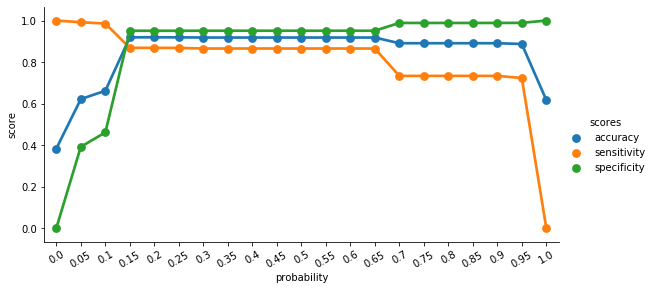

In [105]:
cutoff_plot(y_train_pred_final.Converted, y_train_pred_final.Converted_Pred)

### ROC Curve

In [106]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
  
    plt.figure(figsize=(7, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

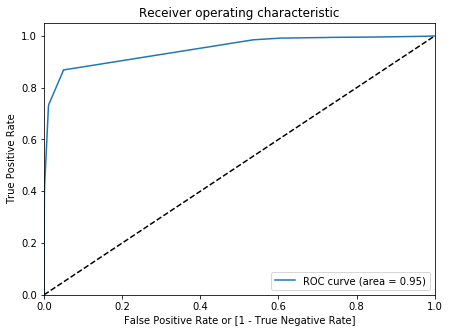

In [107]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Pred)

### Probability Score
The ** ROC AUC (Area Under Curve) ** score comes out to be ** 0.95 ** for the above model.

### Optimal Cut-Off
From the optimal cutoff chart above, it is evident, that P = 0.15 can be the optimal cutoff.
However we should not that, since Sensitivity would be a better judge for this case, we may go with 0.1 too. Depending on how much budget is assigned, and how much False postives (Specificity) can be tolerated, we can go with 0.1 too, which accurately predicts almost all True Positive, whereas eliminating False Positives by about half.

### Final Model Run - Prediction on entire dataset

In [109]:
#Transform the complete set of data.
final_sm = sm.add_constant(leads_data[col_filter])
final_sm_pred = lg.predict(final_sm)

final_sm_pred.values.reshape(-1)

final_pred_y = pd.DataFrame({'Converted':leads_data['Converted'], 'Converted_Pred':final_sm_pred})
final_pred_y['Predicted'] = final_pred_y.Converted_Pred.map(lambda x: 1 if x > 0.9 else 0)

confusion = metrics.confusion_matrix(final_pred_y.Converted, final_pred_y.Predicted)
print('Confusion Matrix:')
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

#Accuracy
print('\tAccuracy\t:', round((TP+TN)*100/(TP+FP+TN+FN)), '%')
# Positive Predictive vlaue/Precision
print('\tPrecision\\PPV\t:', round(TP*100/(TP+FP)), '%')
# Negative Predictive Value
print('\tNPV\t\t:', round(TN*100/(TN + FN)), '%')
# Sensitivity
print('\tSensitivity\t:', round(TP*100/(TP + FN)), '%')
#Specificity
print('\tSpecificity\t:', round(TN*100/(TN+FP)), '%')
#F1 Score
print('\tF1 SCore\t:', round(2*(TP*100/(TP+FP))*(TP*100/(TP + FN))/((TP*100/(TP+FP))+(TP*100/(TP + FN)))), '%')

Confusion Matrix:
[[5604   73]
 [ 925 2617]]
	Accuracy	: 89.0 %
	Precision\PPV	: 97.0 %
	NPV		: 86.0 %
	Sensitivity	: 74.0 %
	Specificity	: 99.0 %
	F1 SCore	: 84.0 %


The model works with similar scores for the entire data set, and the accuracy increases a bit too.
This confirms that the model is not overfitted to the training data.

It also shows us that the cut off can be set to 0.1 or 0.15 depending on how sensitive we want our model to be.

In [94]:
# Probability
print('Probability of joining, from actual conversions\t:', round(final_pred_y.Converted.sum()*100/len(final_pred_y), 2) , '%')
print('Probability of joining, from predictions\t:', round(final_pred_y.Predicted.sum()*100/len(final_pred_y), 2) , '%')

Probability of joining, from actual conversions	: 38.42 %
Probability of joining, from predictions	: 82.34 %


### Final Lead Score for each customer

In [95]:
final_pred_y[['Converted_Pred']]

,Converted_Pred
Prospect ID,
7927b2df-8bba-4d29-b9a2-b6e0beafe620,0.542025
2a272436-5132-4136-86fa-dcc88c88f482,1.000000
8cc8c611-a219-4f35-ad23-fdfd2656bd8a,1.000000
0cc2df48-7cf4-4e39-9de9-19797f9b38cc,1.000000
3256f628-e534-4826-9d63-4a8b88782852,1.000000
...,...
19d6451e-fcd6-407c-b83b-48e1af805ea9,1.000000
82a7005b-7196-4d56-95ce-a79f937a158d,1.000000
aac550fe-a586-452d-8d3c-f1b62c94e02c,1.000000
